Classification Report:
               precision    recall  f1-score   support

          -1       0.48      0.46      0.47        95
           0       0.86      0.93      0.90       778
           1       0.76      0.17      0.28        76

    accuracy                           0.83       949
   macro avg       0.70      0.52      0.55       949
weighted avg       0.82      0.83      0.81       949

Confusion Matrix:
 [[ 44  51   0]
 [ 47 727   4]
 [  0  63  13]]
Test Accuracy: 0.8261327713382508


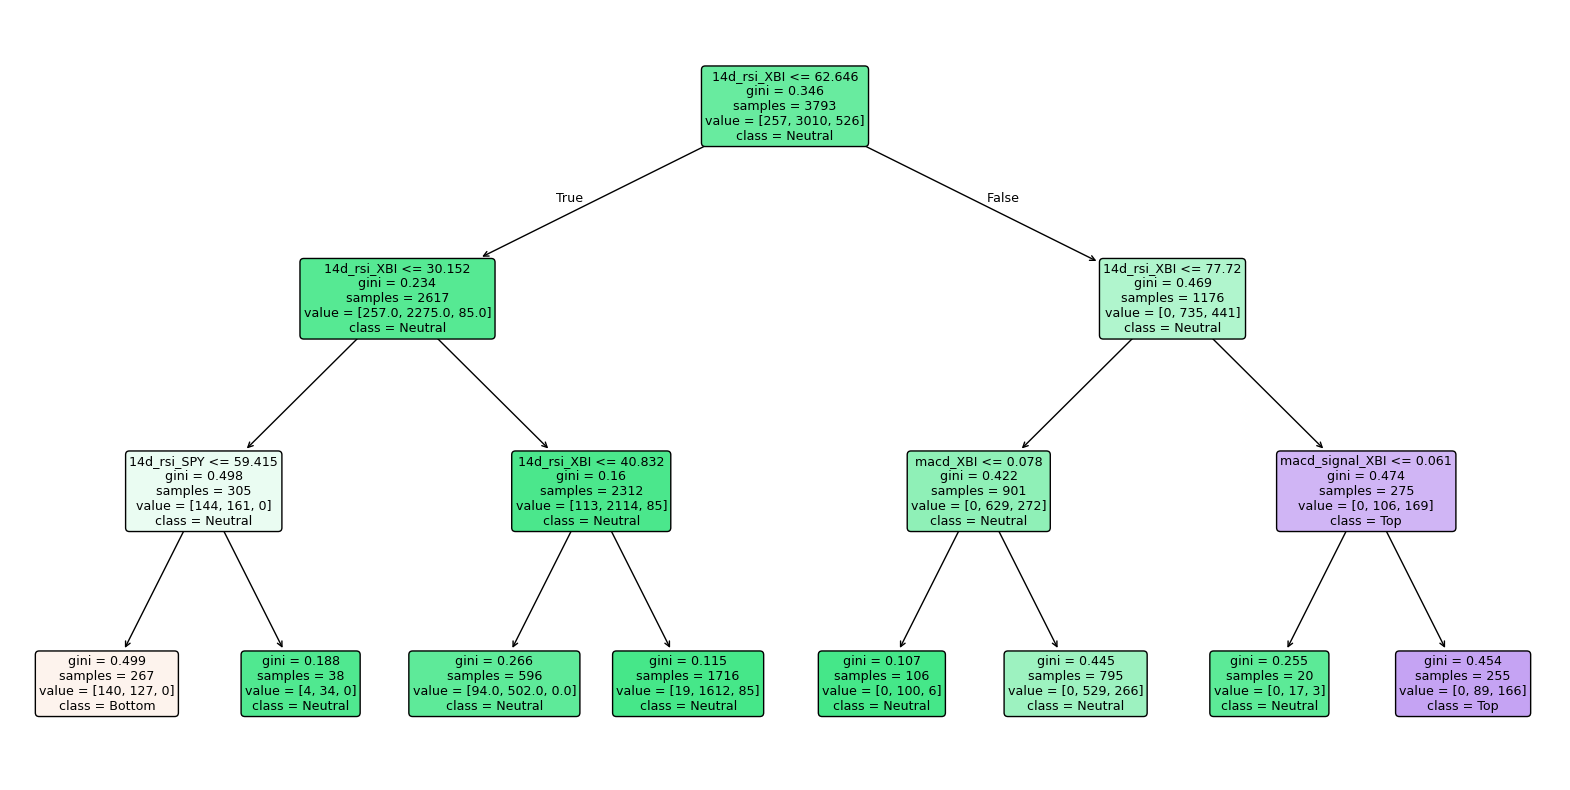

Model saved as decision_tree_model.pkl
Model loaded from decision_tree_model.pkl


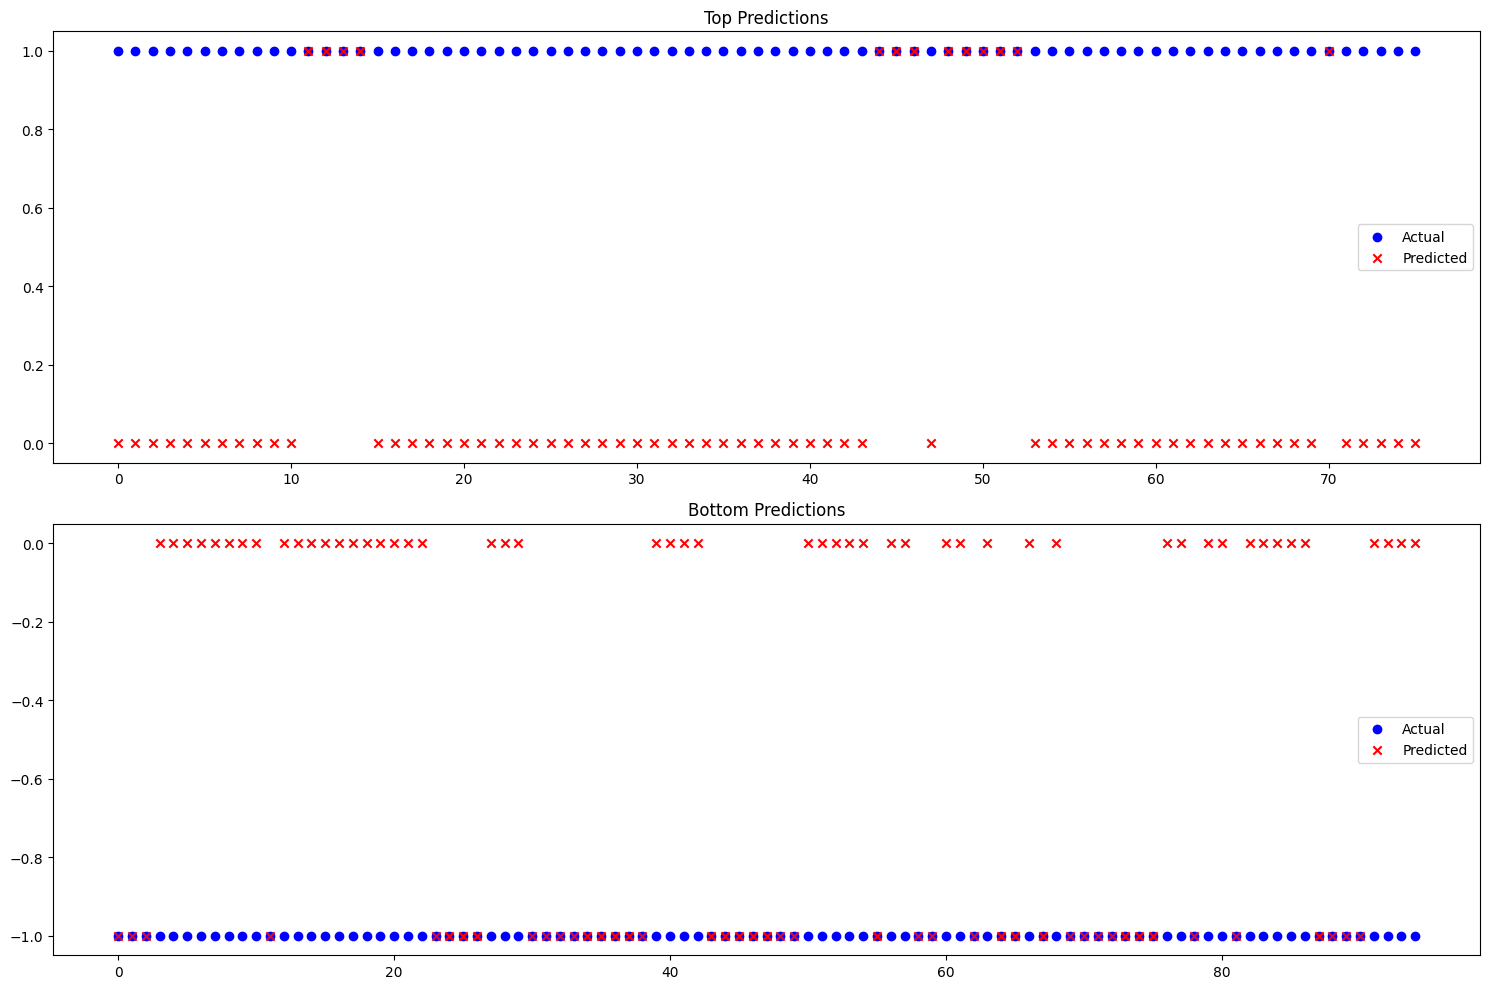

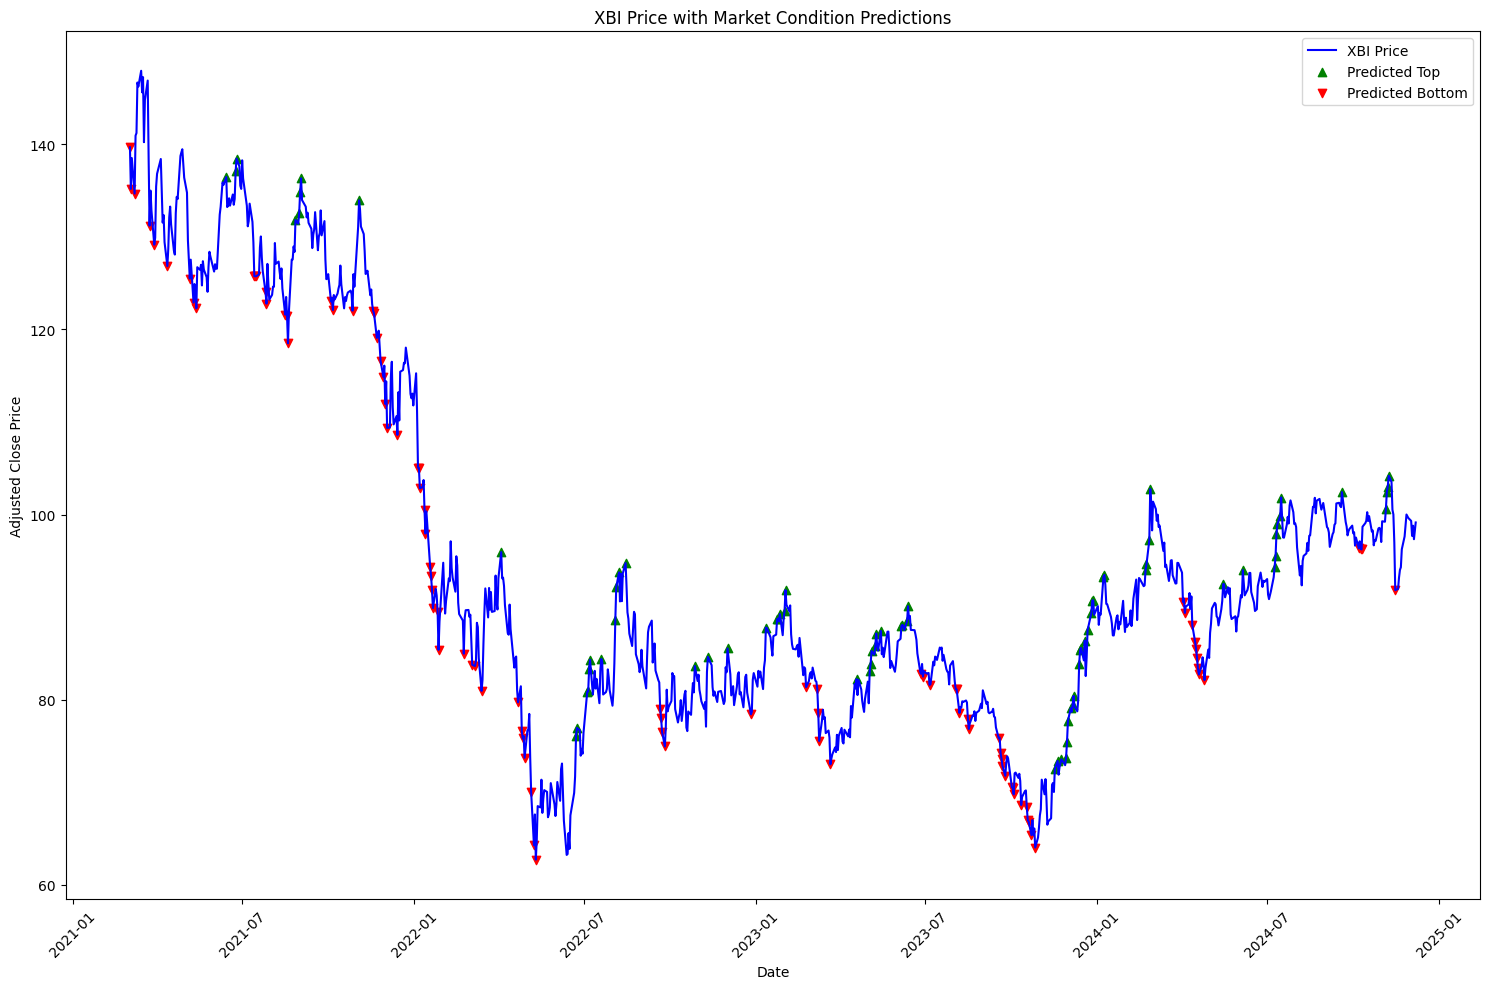

In [ ]:
# %% Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from yahooquery import Ticker
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from data_fetcher import fetch_ticker_data
import pickle,os
import warnings
warnings.filterwarnings("ignore")

# %% Helper functions for technical indicators
def compute_rsi(series, window=14):
    """Compute the Relative Strength Index (RSI) for a given series."""
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

def compute_macd(series, short_window=12, long_window=26, signal_window=9):
    """Compute the MACD and signal line."""
    short_ema = series.ewm(span=short_window, min_periods=1).mean()
    long_ema = series.ewm(span=long_window, min_periods=1).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=signal_window, min_periods=1).mean()
    return macd, signal

def compute_trending_down_percentage(df_ticker_data, period=5):
    """Compute the percentage of stocks in the dataset trending down over the specified period."""
    trending_down = sum(
        df_ticker_data.groupby('symbol').apply(
            lambda stock: stock['adjclose'].iloc[-1] / stock['adjclose'].iloc[-(period + 1)] - 1 < 0
        )
    )
    total_stocks = len(df_ticker_data['symbol'].unique())
    return (trending_down / total_stocks) * 100

def compute_market_breadth_indicators(df_ticker_data, tickers_mini):
    """Compute additional market breadth and sentiment indicators."""
    df_filtered = df_ticker_data[df_ticker_data['symbol'].isin(tickers_mini)]
    
    def is_above_200d_ma(stock_data):
        try:
            return stock_data['adjclose'].iloc[-1] > stock_data['adjclose'].rolling(window=200).mean().iloc[-1]
        except:
            return False
    
    above_200d_ma = df_filtered.groupby('symbol').apply(is_above_200d_ma).sum()
    pct_above_200d_ma = (above_200d_ma / len(tickers_mini)) * 100
    
    def compute_return_std(group):
        try:
            return group['adjclose'].pct_change().std()
        except:
            return 0
    
    market_return_std = df_filtered.groupby('symbol').apply(compute_return_std).mean()
    
    def is_52_week_high(stock_data):
        try:
            return stock_data['adjclose'].iloc[-1] == stock_data['adjclose'].rolling(window=252).max().iloc[-1]
        except:
            return False
    
    def is_52_week_low(stock_data):
        try:
            return stock_data['adjclose'].iloc[-1] == stock_data['adjclose'].rolling(window=252).min().iloc[-1]
        except:
            return False
    
    new_highs = df_filtered.groupby('symbol').apply(is_52_week_high).sum()
    new_lows = df_filtered.groupby('symbol').apply(is_52_week_low).sum()
    new_highs_ratio = (new_highs / len(tickers_mini)) * 100
    new_lows_ratio = (new_lows / len(tickers_mini)) * 100
    
    def compute_correlation(group):
        try:
            returns = group['adjclose'].pct_change()
            return returns
        except:
            return pd.Series()
    
    try:
        daily_returns = df_filtered.groupby('symbol').apply(compute_correlation)
        correlations = daily_returns.corr().mean().mean()
    except:
        correlations = 0
    
    def compute_momentum(stock_data, momentum_window=20):
        try:
            return stock_data['adjclose'].iloc[-1] / stock_data['adjclose'].iloc[-momentum_window] - 1
        except:
            return 0
    
    sector_momentum = df_filtered.groupby('symbol').apply(
        lambda stock: compute_momentum(stock)
    ).mean() * 100
    
    return {
        'pct_above_200d_ma': pct_above_200d_ma,
        'market_return_std': market_return_std,
        'new_highs_ratio': new_highs_ratio,
        'new_lows_ratio': new_lows_ratio,
        'avg_stock_correlation': correlations,
        'sector_momentum': sector_momentum
    }

# %% Data fetching and preprocessing
def load_tickers(file_path):
    """Load tickers from an Excel file."""
    tickers = pd.read_excel(file_path)
    return tickers[tickers.Country == "United States"].Ticker.unique().tolist()

def fetch_data(tickers, period='max', interval='1d'):
    """Fetch data for the tickers."""
    return fetch_ticker_data(tickers, period=period, interval=interval, filename=None)

def prepare_features_and_targets(df_ticker_data, tickers_mini, period=5):
    """Prepare features and targets for modeling."""
    # Filter data for XBI and SPY
    df_xbi = df_ticker_data[df_ticker_data['symbol'] == 'XBI'].copy()
    df_spy = df_ticker_data[df_ticker_data['symbol'] == 'SPY'].copy()
    
    # Calculate indicators for XBI
    df_xbi['7d_ma_XBI'] = df_xbi['adjclose'].rolling(window=7).mean()
    df_xbi['14d_rsi_XBI'] = compute_rsi(df_xbi['adjclose'])
    df_xbi['30d_ma_XBI'] = df_xbi['adjclose'].rolling(window=30).mean()
    df_xbi['macd_XBI'], df_xbi['macd_signal_XBI'] = compute_macd(df_xbi['adjclose'])
    df_xbi['volatility_XBI'] = df_xbi['adjclose'].rolling(window=14).std()
    
    # Compute market breadth indicators
    market_breadth = compute_market_breadth_indicators(df_ticker_data, tickers_mini)
    
    # Add market breadth indicators to the XBI dataframe
    df_xbi['pct_above_200d_ma'] = market_breadth['pct_above_200d_ma']
    df_xbi['market_return_std'] = market_breadth['market_return_std']
    df_xbi['new_highs_ratio'] = market_breadth['new_highs_ratio']
    df_xbi['new_lows_ratio'] = market_breadth['new_lows_ratio']
    df_xbi['avg_stock_correlation'] = market_breadth['avg_stock_correlation']
    df_xbi['sector_momentum'] = market_breadth['sector_momentum']
    
    # Define target for XBI: Local maxima = Top, Local minima = Bottom
    df_xbi['target_XBI'] = 0
    df_xbi.loc[df_xbi['adjclose'] == df_xbi['adjclose'].rolling(window=30).max(), 'target_XBI'] = 1
    df_xbi.loc[df_xbi['adjclose'] == df_xbi['adjclose'].rolling(window=30).min(), 'target_XBI'] = -1
    # OUTPUT THIS

    # Calculate indicators for SPY
    df_spy['7d_ma_SPY'] = df_spy['adjclose'].rolling(window=7).mean()
    df_spy['14d_rsi_SPY'] = compute_rsi(df_spy['adjclose'])
    df_spy['30d_ma_SPY'] = df_spy['adjclose'].rolling(window=30).mean()
    df_spy['macd_SPY'], df_spy['macd_signal_SPY'] = compute_macd(df_spy['adjclose'])
    df_spy['volatility_SPY'] = df_spy['adjclose'].rolling(window=14).std()
    
    # Merge SPY features into XBI
    df_combined = pd.merge(
        df_xbi, 
        df_spy[['date', 'adjclose', '7d_ma_SPY', '14d_rsi_SPY', '30d_ma_SPY', 'macd_SPY', 'macd_signal_SPY', 'volatility_SPY']], 
        on='date', 
        suffixes=('_XBI', '_SPY')
    )
    
    # Filter columns for features and target
    feature_columns = ['7d_ma_XBI', '14d_rsi_XBI', '30d_ma_XBI', 'macd_XBI', 'macd_signal_XBI', 
                       'volatility_XBI', 
                       '7d_ma_SPY', '14d_rsi_SPY', '30d_ma_SPY', 'macd_SPY', 'macd_signal_SPY', 'volatility_SPY']

    #feature_columns = ['new_highs_ratio', 'new_lows_ratio',  '30d_ma_SPY']
    X_combined = df_combined[feature_columns].fillna(0)  # Handle any missing values in features
    y_combined = df_combined['target_XBI']  # The target variable
    
    return X_combined, y_combined

# %% Model training and evaluation
def initialize_models():
    """Initialize and return a dictionary of models."""
    return {
        'DecisionTree': DecisionTreeClassifier(
            max_depth=3,  # Limit the depth of the tree
            min_samples_split=10,  # Minimum samples required to split an internal node
            min_samples_leaf=5,  # Minimum samples required to be at a leaf node
            random_state=42
        )  
    }

def train_and_evaluate_model(X_combined, y_combined):
    """Train and evaluate the decision tree model."""
    X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42,shuffle=False)
     
    models = initialize_models()
    model = models['DecisionTree']
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Test Accuracy:", accuracy_score(y_test, y_pred))
    
    # Plot the decision tree
    plt.figure(figsize=(20,10))
    plot_tree(model, 
              feature_names=X_combined.columns, 
              class_names=['Bottom', 'Neutral', 'Top'], 
              filled=True, 
              rounded=True, 
              impurity=True)
    plt.show()

def plot_predictions_vs_actual(X_combined, y_combined, model):
    """
    Plot actual XBI prices and model predictions
    
    Parameters:
    - X_combined: Feature matrix
    - y_combined: Actual target values
    - model: Trained decision tree classifier
    """
    # Split data without shuffling to maintain time sequence
    X_train, X_test, y_train, y_test = train_test_split(
        X_combined, y_combined, 
        test_size=0.2, 
        random_state=42, 
        shuffle=False
    )
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Create a figure with subplots
    plt.figure(figsize=(15, 10))
    
    # Plot for Top predictions
    plt.subplot(2, 1, 1)
    top_indices = y_test == 1
    plt.scatter(
        range(sum(top_indices)), 
        y_test[top_indices], 
        label='Actual', 
        color='blue'
    )
    plt.scatter(
        range(sum(top_indices)), 
        y_pred[top_indices], 
        label='Predicted', 
        color='red', 
        marker='x'
    )
    plt.title('Top Predictions')
    plt.legend()
    
    # Plot for Bottom predictions
    plt.subplot(2, 1, 2)
    bottom_indices = y_test == -1
    plt.scatter(
        range(sum(bottom_indices)), 
        y_test[bottom_indices], 
        label='Actual', 
        color='blue'
    )
    plt.scatter(
        range(sum(bottom_indices)), 
        y_pred[bottom_indices], 
        label='Predicted', 
        color='red', 
        marker='x'
    )
    plt.title('Bottom Predictions')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def plot_predictions_with_price(X_combined, y_combined, df_ticker_data, model):
    # Split data without shuffling to maintain time sequence
    X_train, X_test, y_train, y_test = train_test_split(
        X_combined, y_combined, test_size=0.2, random_state=42, shuffle=False
    )
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Get XBI price data
    df_xbi = df_ticker_data[df_ticker_data['symbol'] == 'XBI'].copy()
    
    # Reset index to ensure alignment
    df_xbi = df_xbi.reset_index(drop=True)
    
    # Create a slice of df_xbi corresponding to the test set
    df_xbi_test = df_xbi.iloc[-len(y_test):]
    
    # Create figure with subplots
    plt.figure(figsize=(15, 10))
    
    # Plot actual XBI prices
    plt.plot(df_xbi_test['date'], df_xbi_test['adjclose'], label='XBI Price', color='blue')
    
    # Highlight prediction points
    top_indices = y_test == 1
    bottom_indices = y_test == -1
    
    plt.scatter(
        df_xbi_test.loc[top_indices, 'date'], 
        df_xbi_test.loc[top_indices, 'adjclose'], 
        color='green', 
        marker='^', 
        label='Predicted Top'
    )
    
    plt.scatter(
        df_xbi_test.loc[bottom_indices, 'date'], 
        df_xbi_test.loc[bottom_indices, 'adjclose'], 
        color='red', 
        marker='v', 
        label='Predicted Bottom'
    )
    
    plt.title('XBI Price with Market Condition Predictions')
    plt.xlabel('Date')
    plt.ylabel('Adjusted Close Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# %% Model training and evaluation
def train_and_evaluate_model(X_combined, y_combined, save_model=True):
    """Train and evaluate the decision tree model."""
    X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42,shuffle=False)
     
    models = initialize_models()
    model = models['DecisionTree']
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Test Accuracy:", accuracy_score(y_test, y_pred))
    
    # Plot the decision tree
    plt.figure(figsize=(20,10))
    plot_tree(model, 
              feature_names=X_combined.columns, 
              class_names=['Bottom', 'Neutral', 'Top'], 
              filled=True, 
              rounded=True, 
              impurity=True)
    plt.show()
    
    # Save the model if specified
    if save_model:
        model_filename = "decision_tree_model.pkl"
        with open(model_filename, 'wb') as f:
            pickle.dump(model, f)
        print(f"Model saved as {model_filename}")
    
    return model

# %% Load the saved model
def load_model(model_filename="decision_tree_model.pkl"):
    """Load a saved model from a pickle file."""
    if os.path.exists(model_filename):
        with open(model_filename, 'rb') as f:
            model = pickle.load(f)
        print(f"Model loaded from {model_filename}")
        return model
    else:
        print(f"{model_filename} not found.")
        return None

# %% Main script execution
if __name__ == "__main__":
    # Load tickers and fetch data
    tickers = load_tickers("Input/Complete-List-of-Biotech-Stocks-Listed-on-NASDAQ-Jan-1-24.xlsx")
    tickers_mini = tickers 
    benchmark_tickers = ["XBI", "SPY"]
    tickers_full = tickers_mini + benchmark_tickers
    
    # Fetch data
    df_ticker_daily = fetch_data(tickers_full)

    # Prepare features and targets for model
    X_combined, y_combined = prepare_features_and_targets(df_ticker_daily, tickers_full, period=5)

    models = initialize_models()
    model = models['DecisionTree']
    model.fit(X_combined, y_combined)  # Train on most data

    # Train and evaluate the model, save it after training
    trained_model = train_and_evaluate_model(X_combined, y_combined, save_model=True)

    loaded_model = load_model()  

    # If model is loaded, you can proceed with prediction or further evaluation
    if loaded_model:
        plot_predictions_vs_actual(X_combined, y_combined, loaded_model)
        plot_predictions_with_price(X_combined, y_combined, df_ticker_daily, loaded_model)